### - Scikit-learn confusion matrix from:
    - create vector of predictions for y_pred
    - y_true = df['intent']
    - display confusion matrix

### - New Embedding
- [DONE] get new embedding -> SBert Sentence Transformers embedding
 train again
### - Confusion Matrix
    - [ ] for old model
    - [ ] for new trained model

### - Use best trained model to classify unlabeled utterances
### - Predict probability (predict_proba) of the high probability labels
    # then talk with Maria to see if the unsupervised labels are correct
        # start with highest probability until uncertainty of human label
    # if so, add to master dataframe

### - Unsupervised learning approaches for unlabeled utterances

## Tasks
- [DONE] Calculate .score on training set for latest experiment
- [DONE] Calculate .score on test set for latest experiment
- [DONE] Create dict of training set score and test set score for each model (performance of model)
    hyper_dict = {
        'train_score': float,
        'test_score': float
        }
- [DONE] Hyperparameters: text descr of what hyperparameters used (c value, class weights)
- [DONE] Append dict to list: "hyperparameter_table_list"
- [DONE] df_hyper = pd.DataFrame(hyper_list) # list from prior task "hyperlist"
- [ ] Review df_hyper: overfitting or underfitting
- [ ] df_hyper.sort_values('test_score') # sorts in ascending (increasing) order (look at last 2 rows)
- [ ] Based on prior results, change c or class weight (hyperparameters)
- [ ] Go back to step 1
    - [ ] table with 

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
import spacy
from sentence_transformers import SentenceTransformer

In [53]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
matplotlib.rcParams['figure.figsize'] = [6, 5]
%matplotlib inline
import seaborn as sns
sns.set_theme()

from openTSNE import TSNE

ValueError: context must be in paper, notebook, talk, poster

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

In [5]:
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score

In [6]:
hyperparams_list = []
pd.options.display.max_columns = 1000

In [7]:
# FIXME: not important to preprocess and load existing embeddings

utterance_intent_english_csv = './data/utterance_intent_english.csv'
embedding_spacy_intent_csv = './data/embedding_spacy_intent.csv'
embedding_sbert_intent_csv = './data/embedding_sbert_intent.csv'
concat_labeled_unlabeled_utterances_english_csv = './data/concat_labeled_unlabeled_utterances_english.csv'

utterances_json = './utterances-labeled-english.json'
unlabeled_utterances_csv = './data/utterance_english.csv'

In [8]:
df = pd.read_csv('data/concat_labeled_unlabeled_utterances_english.csv')
df = df[['utterance', 'intent']].copy()
print(df.columns)
print(df.shape)
utterances = list(df['utterance'].fillna(''))
intents = list(df['intent'].copy().fillna('unknown'))
counts = pd.Series(Counter(intents)).sort_values()
counts

Index(['utterance', 'intent'], dtype='object')
(1083, 2)


how_are_you                   1
stories_module                1
both_languages                2
quiz_module                   3
information                   3
ask_question                  3
restart                       4
watched_videos                4
how_to_get_involved           4
insurance_for_work            6
where_are_you_from            7
testing_you                   7
no                            7
other_languages               7
what_is_unsafe_migration      8
main_menu                     8
addressing_maya               8
i_love_you                    9
scary_or_terrible             9
stupid_bot                   10
documents_needed             11
what_is_trafficking          13
yes                          14
continue                     14
safe_behaviors               15
online_safety                18
change_language              24
who_are_you_maya             24
thank_you                    26
emergency                    30
goodbye                      34
hello   

In [12]:
new_utterances = []
new_intents = []
for label in counts.index:
    while counts[label] < 3:
        print(f'Input a new utterance for "{label}". Examples:\n    ')
        print('\n    '.join(df['utterance'][df['intent'] == label]))
        utt = input('YOU: ')
        new_utterances.append(utt)
        new_intents.append(label)
        counts[label] += 1
    
df = df.to_csv('data/augumented_utterances_all.csv')

Input a new utterance for "how_are_you". Examples:
    
"Hello how are you doing today"
YOU: Hi how are you?
Input a new utterance for "how_are_you". Examples:
    
"Hello how are you doing today"
YOU: How are you doin
Input a new utterance for "stories_module". Examples:
    
Can I read story
YOU: read a story
Input a new utterance for "stories_module". Examples:
    
Can I read story
YOU: tell me a story
Input a new utterance for "both_languages". Examples:
    
"Both languageSpeak me"
    "Both"
YOU: I speak both languages


In [15]:
intents += intents
utterances += utterances
counts = pd.Series(Counter(intents)).sort_values()
counts

how_are_you                    2
stories_module                 2
both_languages                 4
quiz_module                    6
information                    6
ask_question                   6
restart                        8
watched_videos                 8
how_to_get_involved            8
insurance_for_work            12
where_are_you_from            14
testing_you                   14
no                            14
other_languages               14
what_is_unsafe_migration      16
main_menu                     16
addressing_maya               16
i_love_you                    18
scary_or_terrible             18
stupid_bot                    20
documents_needed              22
what_is_trafficking           26
yes                           28
continue                      28
safe_behaviors                30
online_safety                 36
change_language               48
who_are_you_maya              48
thank_you                     52
emergency                     60
goodbye   

In [16]:
nlp = 'en_core_web_md'
try:
    nlp = spacy.load(nlp)
except OSError:
    spacy.cli.download(nlp)
nlp = spacy.load(nlp) if isinstance(nlp, str) else nlp

# X_spacy = pd.DataFrame([nlp(s).vector for s in utterances])
# Y_spacy = pd.DataFrame([nlp(s).vector for s in intents])
# print(X_spacy.shape)
# print(Y_spacy.shape)

In [17]:
# https://www.sbert.net/
sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [18]:
X_sbert = pd.DataFrame([sbert.encode(s) for s in utterances])
Y_sbert = pd.DataFrame([sbert.encode(s) for s in intents])
print(X_sbert.shape)
print(Y_sbert.shape)

(2166, 384)
(2166, 384)


In [28]:
X = X_sbert.values
y = intents

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42) 

In [30]:
hyperparams = dict(C=1, class_weight='balanced', random_state=1, max_iter=10000, multi_class='auto')
model = LogisticRegression(**hyperparams)

In [31]:
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=10000, random_state=1)

In [35]:
model.classes_

array(['OK', 'addressing_maya', 'ask_question', 'both_languages',
       'change_language', 'continue', 'documents_needed', 'emergency',
       'goodbye', 'hello', 'how_are_you', 'how_to_get_involved',
       'i_love_you', 'information', 'insurance_for_work', 'main_menu',
       'no', 'online_safety', 'other_languages', 'quiz_module', 'restart',
       'safe_behaviors', 'scary_or_terrible', 'stories_module',
       'stupid_bot', 'testing_you', 'thank_you', 'unknown',
       'watched_videos', 'what_is_trafficking',
       'what_is_unsafe_migration', 'where_are_you_from',
       'who_are_you_maya', 'yes'], dtype='<U24')

In [97]:
y_test_pred = model.predict(X_test)
confusion_test = pd.DataFrame(
    confusion_matrix(
        y_test, y_test_pred, labels=model.classes_),
    index=model.classes_,
    columns=model.classes_)

y_pred = model.predict(X)
confusion_all = pd.DataFrame(
    confusion_matrix(
        y, y_pred, labels=model.classes_),
    index=model.classes_,
    columns=model.classes_)

confusion_test

OK  addressing_maya  ask_question  both_languages  \
OK                        19                0             0               0   
addressing_maya            0                2             0               0   
ask_question               0                0             0               0   
both_languages             0                0             0               0   
change_language            0                0             0               0   
continue                   0                0             0               0   
documents_needed           0                0             0               0   
emergency                  0                0             0               0   
goodbye                    0                0             0               0   
hello                      0                0             0               0   
how_are_you                0                0             0               0   
how_to_get_involved        0                0             0               0   
i_love_you                 0                0             0               0   
information                0                0             0               0   
insurance_for_work         0                0             0               0   
main_menu                  0                0             0               0   
no                         0                0             0               0   
online_safety              0                0             0               0   
other_languages            0                0             0               0   
quiz_module                0                0             0               0   
restart                    0                0             0               0   
safe_behaviors             0                0             0               0   
scary_or_terrible          0                0             0               0   
stories_module             0                0             0               0   
stupid_bot                 0                0             0               0   
testing_you                0                0             0               0   
thank_you                  0                0             0               0   
unknown                    2                0             0               0   
watched_videos             0                0             0               0   
what_is_trafficking        0                0             0               0   
what_is_unsafe_migration   0                0             0               0   
where_are_you_from         0                0             0               0   
who_are_you_maya           0                0             0               0   
yes                        0                0             0               0   

                          change_language  continue  documents_needed  \
OK                                      0         0                 0   
addressing_maya                         0         0                 0   
ask_question                            0         0                 0   
both_languages                          0         0                 0   
change_language                         1         0                 0   
continue                                0         0                 0   
documents_needed                        0         0                 2   
emergency                               0         0                 0   
goodbye                                 0         0                 0   
hello                                   0         0                 0   
how_are_you                             0         0                 0   
how_to_get_involved                     0         0                 0   
i_love_you                              0         0                 0   
information                             0         0                 0   
insurance_for_work                      0         0                 0   
main_menu                               0         0                 0   
no                 

In [98]:
confusion_test_pct = (confusion_test / confusion_test.sum()).fillna(0).round(2)
confusion_test_pct
confusion_all_pct = (confusion_all / confusion_all.sum()).fillna(0).round(2)
confusion_all_pct

OK  addressing_maya  ask_question  both_languages  \
OK                        0.88             0.00           0.0             0.0   
addressing_maya           0.00             0.89           0.0             0.0   
ask_question              0.00             0.00           1.0             0.0   
both_languages            0.00             0.00           0.0             1.0   
change_language           0.00             0.00           0.0             0.0   
continue                  0.00             0.00           0.0             0.0   
documents_needed          0.00             0.00           0.0             0.0   
emergency                 0.00             0.00           0.0             0.0   
goodbye                   0.00             0.00           0.0             0.0   
hello                     0.00             0.00           0.0             0.0   
how_are_you               0.00             0.00           0.0             0.0   
how_to_get_involved       0.00             0.00           0.0             0.0   
i_love_you                0.00             0.00           0.0             0.0   
information               0.00             0.00           0.0             0.0   
insurance_for_work        0.00             0.00           0.0             0.0   
main_menu                 0.00             0.00           0.0             0.0   
no                        0.00             0.00           0.0             0.0   
online_safety             0.00             0.00           0.0             0.0   
other_languages           0.00             0.00           0.0             0.0   
quiz_module               0.00             0.00           0.0             0.0   
restart                   0.00             0.00           0.0             0.0   
safe_behaviors            0.00             0.00           0.0             0.0   
scary_or_terrible         0.00             0.00           0.0             0.0   
stories_module            0.00             0.00           0.0             0.0   
stupid_bot                0.00             0.00           0.0             0.0   
testing_you               0.00             0.00           0.0             0.0   
thank_you                 0.00             0.00           0.0             0.0   
unknown                   0.12             0.11           0.0             0.0   
watched_videos            0.00             0.00           0.0             0.0   
what_is_trafficking       0.00             0.00           0.0             0.0   
what_is_unsafe_migration  0.00             0.00           0.0             0.0   
where_are_you_from        0.00             0.00           0.0             0.0   
who_are_you_maya          0.00             0.00           0.0             0.0   
yes                       0.00             0.00           0.0             0.0   

                          change_language  continue  documents_needed  \
OK                                   0.03      0.00               0.0   
addressing_maya                      0.00      0.00               0.0   
ask_question                         0.00      0.00               0.0   
both_languages                       0.00      0.00               0.0   
change_language                      0.80      0.00               0.0   
continue                             0.00      0.72               0.0   
documents_needed                     0.00      0.00               1.0   
emergency                            0.00      0.00               0.0   
goodbye                              0.00      0.00               0.0   
hello                                0.00      0.00               0.0   
how_are_you                          0.00      0.00               0.0   
how_to_get_involved                  0.00      0.00               0.0   
i_love_you                           0.00      0.00               0.0   
information                          0.00      0.00               0.0   
insurance_for_work                   0.00      0.00               0.0   
main_menu               

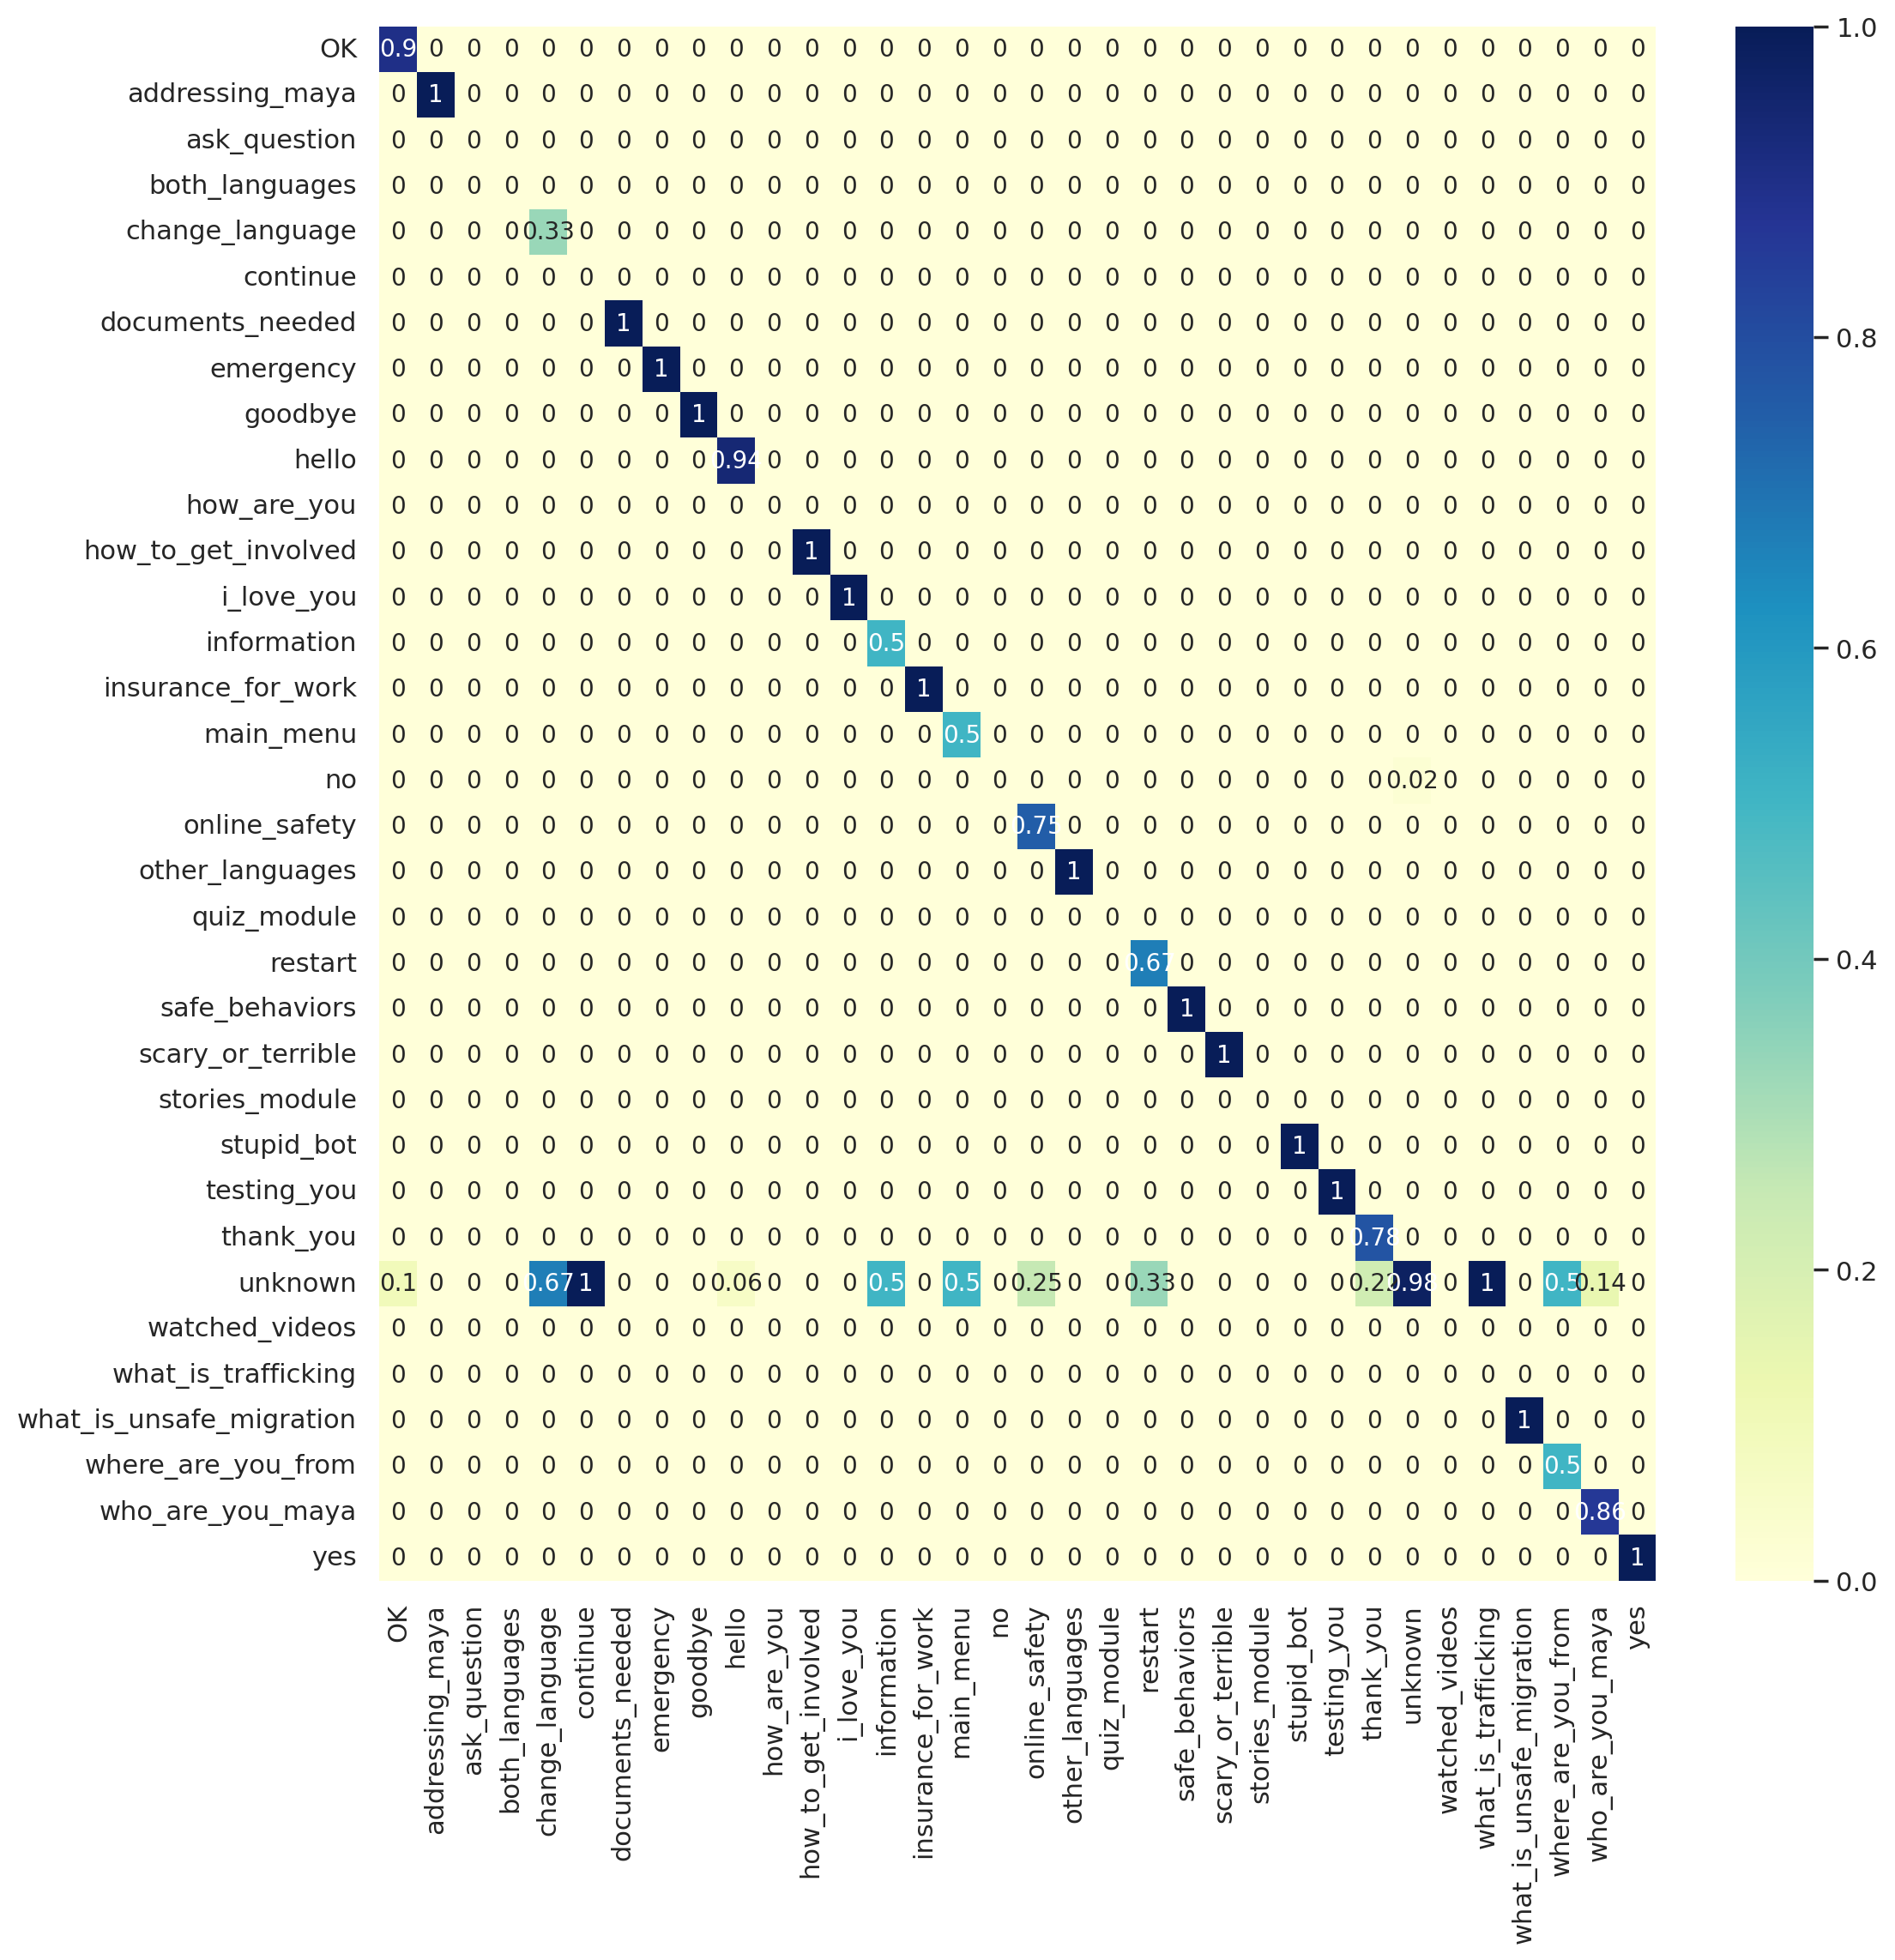

In [99]:
plt.rcParams['figure.figsize'] = [12,12]
fig = plt.figure(figsize=[12,12], dpi=200)
ax = fig.add_subplot(111)
# annot = []
# for r, row in confusion_test_pct.iterrows():
#     annot.append([])
#     for c in row:
#         annot[-1].append(str(c)[1:])
cax = sns.heatmap(confusion_test_pct, annot=True, cmap="YlGnBu")

In [100]:
plt.rcParams['figure.figsize'] = [12,12]
fig = plt.figure(figsize=[12,12], dpi=200)
ax = fig.add_subplot(111)
# annot = []
# for r, row in confusion_test_pct.iterrows():
#     annot.append([])
#     for c in row:
#         annot[-1].append(str(c)[1:])
cax = sns.heatmap(confusion_all_pct, annot=True, cmap="YlGnBu")

In [64]:
plt.rcParams['figure.figsize'] = [8,6]
fig = plt.figure(figsize=[8,6], dpi=300)
ax = fig.add_subplot(111)
cax = sns.heatmap(confusion, vmin=0, vmax=1)
# cax = ax.matshow(confusion.values, cmap='ocean')
# plt.grid(False)
# fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(model.classes_), rotation=90)
ax.set_yticklabels([''] + list(model.classes_))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

/tmp/ipykernel_10500/490257162.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(model.classes_), rotation=90)
/tmp/ipykernel_10500/490257162.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(model.classes_))


In [ ]:
hyperparams['test_score'] = model.score(X_spacy_embeddings_test, y_test)
hyperparams['spacy_train_score'] = model.score(X_spacy_embeddings_train, y_train)

In [ ]:
hyperparams_list.append(hyperparams)

In [ ]:
pd.DataFrame(hyperparams_list)

In [ ]:
# SBert sentence transformers embeddings logistic regression
clf_sbert_embeddings = LogisticRegression(C=1, random_state=1, \
    max_iter=300).fit(X_sbert_embeddings_train, y_train)

In [ ]:
y_pred_sentence_transformers_embeddings = clf_sbert_embeddings.predict(X_sbert_embeddings_test)

In [ ]:
sbert_test_score = clf_sbert_embeddings.score(X_sbert_embeddings_test, y_test)
sbert_test_score

In [ ]:
sbert_train_score = clf_sbert_embeddings.score(X_sbert_embeddings_train, y_train)
sbert_train_score

In [ ]:
hyper_dict_spacy = {
        'train_score': spacy_train_score,
        'test_score': spacy_test_score
}
hyper_dict_sbert = {
        'train_score': sbert_train_score,
        'test_score': sbert_test_score
}
print('Spacy: ', hyper_dict_spacy)
print('SBert: ', hyper_dict_sbert)

In [ ]:
hyper_list_copy = hyper_list.copy()

In [ ]:
hyper_list.append(hyper_dict_spacy)

In [ ]:
hyper_list_spacy = hyper_list
hyper_list_spacy

In [ ]:
hyper_list_copy.append(hyper_dict_sbert)

In [ ]:
hyper_list_sbert = hyper_list_copy
hyper_list_sbert

In [ ]:
hyper_list_sbert

In [ ]:
hyper_spacy_df = pd.DataFrame(hyper_list_spacy)
hyper_spacy_df

In [ ]:
hyper_sbert_df = pd.DataFrame(hyper_list_sbert)
hyper_sbert_df